In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data
from sysidentpy.metrics import root_relative_squared_error, mean_forecast_error

# To have the Matplotlib plots centered in the notebook
from IPython.core.display import HTML
HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import display_nx_model

$$\Large \text{Single Input Single Output}$$
$$\large y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$$

In [2]:
# Generate 1000 Samples with White noise
# In this cases the SISO data is represented by an input x, a uniformly distributed
# random variable, and the scalar output y. The model attempts to identify the transfer
# function x -> y.
N = 1000
x_train, x_valid, y_train, y_valid = get_siso_data(n=N,
                                                   colored_noise=False,
                                                   sigma=0.0001,
                                                   train_percentage=90)
t_train, t_test = train_test_split(list(range(N)), test_size=0.1, shuffle=False)

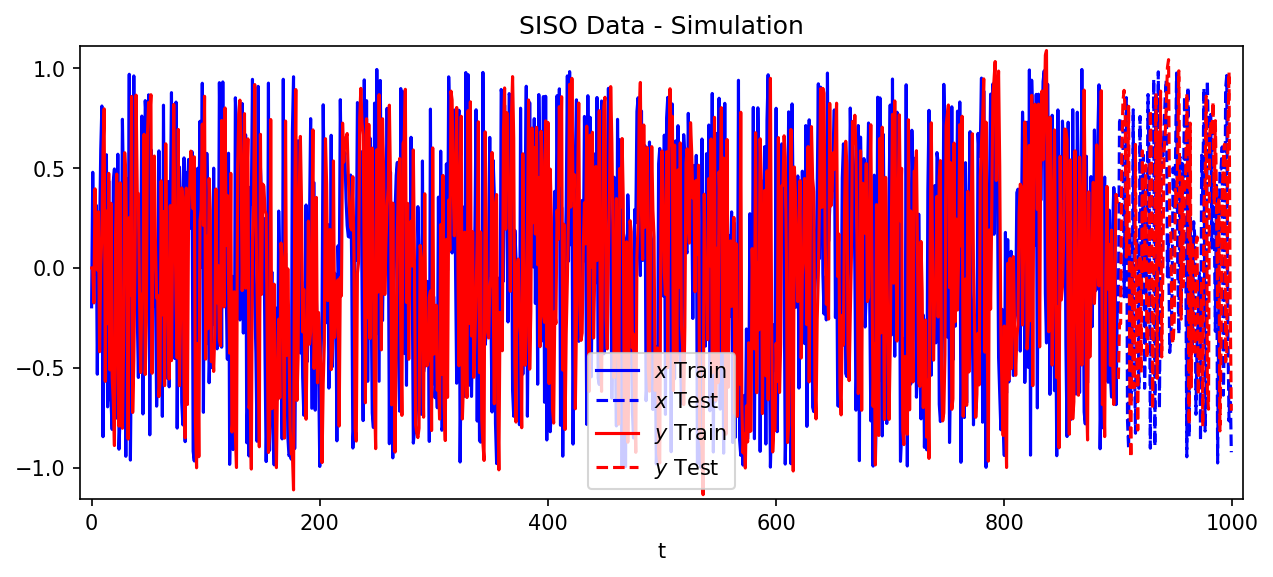

In [3]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SISO Data - Simulation')
plt.plot(t_train, x_train, "b", label="$x$ Train")
plt.plot(t_test, x_valid, "b--", label="$x$ Test")
plt.plot(t_train, y_train, "r", label="$y$ Train")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [4]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=2, xlag=2,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)
# Train model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train, y=y_train)
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y')
# Simulate model for the state X
sim_y = nx_model.predict(X=x_valid, y=y_valid[:2])

# Stack results for models and predictions
narmax_model = np.array([coeffs_y])
narmax_sim = sim_y

y(k) = 9.000E-01 x1(k-2) + 2.000E-01 y(k-1) + 1.000E-01 x1(k-1)y(k-1)


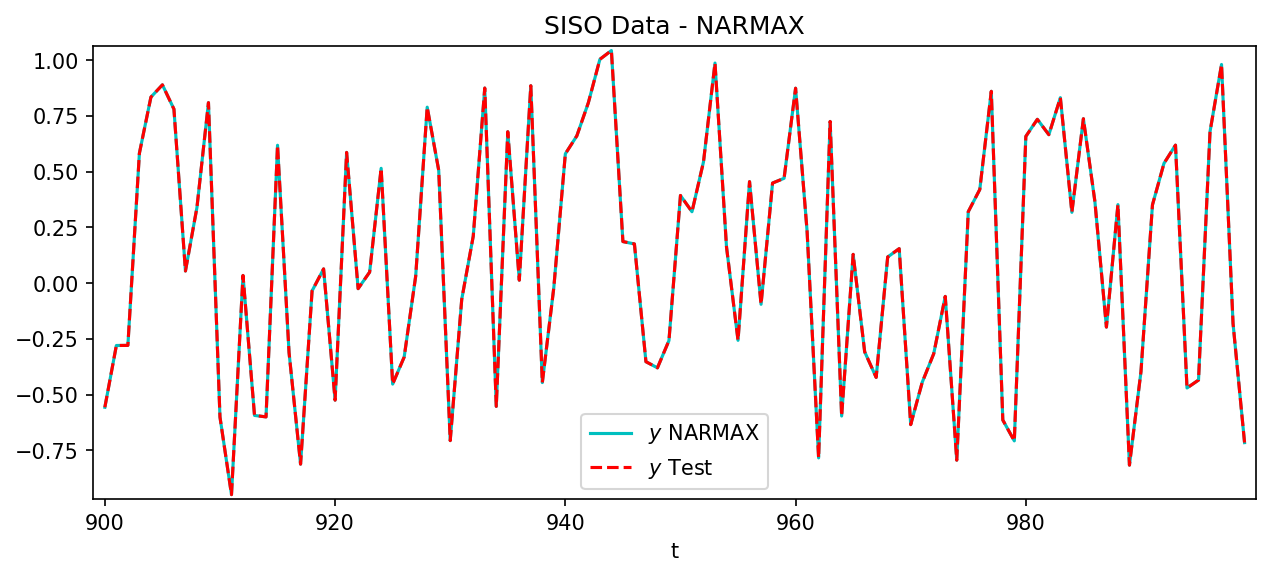

In [5]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SISO Data - NARMAX')
plt.plot(t_test, narmax_sim, "c", label="$y$ NARMAX")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [6]:
# Define SINDy Model with control (SINDYc)
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['y', 'x_k-1', 'x_k-2'],
    discrete_time=True
)
# Fit model and get time taken
u_train = np.hstack((x_train[1:], x_train[:-1]))
tic = time.time()
sindy_model.fit(y_train[1:], u=u_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
first = np.hstack((x_valid[0], x_train[-1])) # First Input is needed to simulate y_valid[1]
u_test = np.hstack((x_valid[1:], x_valid[:-1]))
u_test = np.vstack((first, u_test)).reshape(-1, 1, u_train.shape[1])
sindy_sim = sindy_model.simulate(y_valid[0], t=len(y_valid), u=u_test)[:,0]

y[k+1] = 0.200 y[k] + 0.900 x_k-2[k] + 0.100 y[k] x_k-1[k]


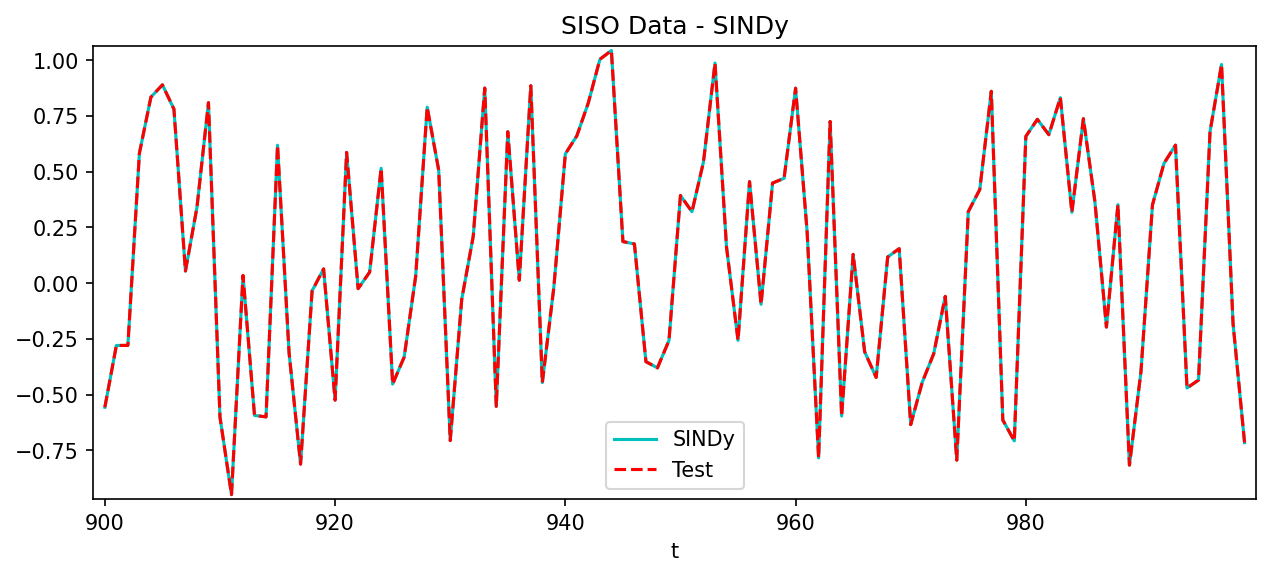

In [7]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('SISO Data - SINDy')
plt.plot(t_test, sindy_sim, "c", label="SINDy")
plt.plot(t_test, y_valid, "r--", label="Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [8]:
# Metrics DataFrame
get_metrics_df(y_valid, [3], sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[3.0],[0.0],3.0,-0.000004,1.140406e-08,14.142093,1.0,0.010794
NARMAX,[3.0],[0.0],3.0,-0.000004,1.136158e-08,0.000196,1.0,0.030210


$$\Large \text{Multiple Inputs Single Output}$$
$$\large y_k = 0.4y_{k-1}^2 + 0.1y_{k-1}x1_{k-1} + 0.6x2_{k-1} -0.3x1_{k-1}x2_{k-2} + e_{k}$$

In [9]:
# Generate 1000 Samples with White noise
# In this cases the MISO data is represented by an input x, a uniformly distributed
# random vector, and the scalar output y. The model attempts to identify the transfer
# function x -> y.
N = 1000
x_train, x_valid, y_train, y_valid = get_miso_data(n=N,
                                                   colored_noise=False,
                                                   sigma=0.001,
                                                   train_percentage=90)
t_train, t_test = train_test_split(list(range(N)), test_size=0.1, shuffle=False)

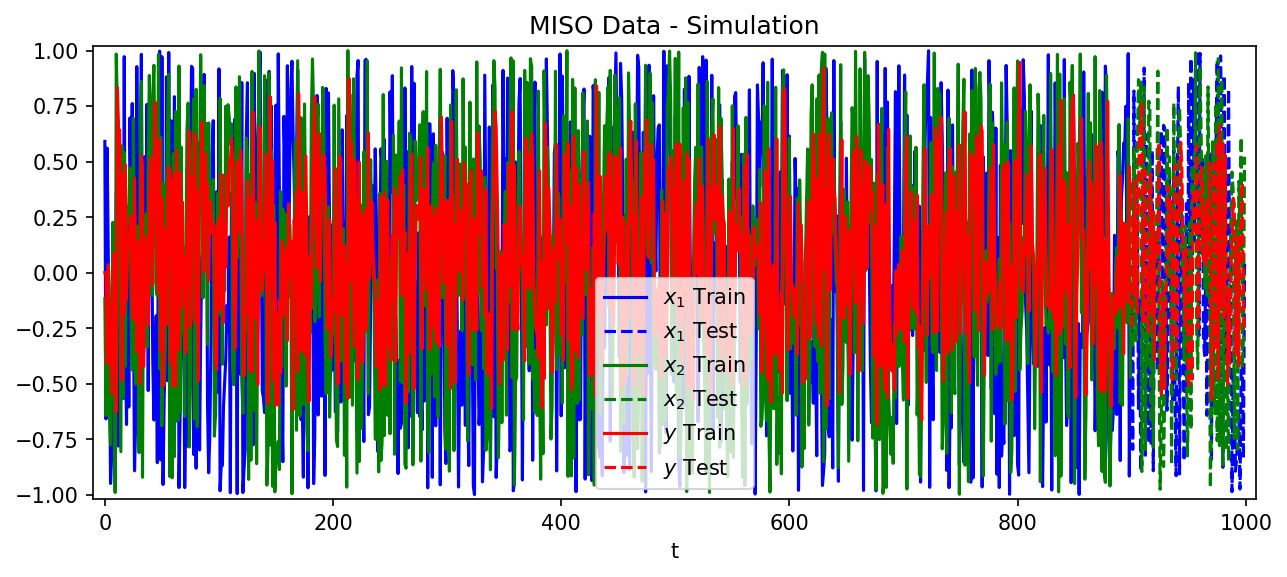

In [10]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('MISO Data - Simulation')
plt.plot(t_train, x_train[:,0], "b", label="$x_1$ Train")
plt.plot(t_test, x_valid[:,0], "b--", label="$x_1$ Test")
plt.plot(t_train, x_train[:,1], "g", label="$x_2$ Train")
plt.plot(t_test, x_valid[:,1], "g--", label="$x_2$ Test")
plt.plot(t_train, y_train, "r", label="$y$ Train")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [11]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=2, xlag=[[1, 2], [1, 2]],
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)
# Train model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train, y=y_train)
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y')
# Simulate model for the state X
sim_y = nx_model.predict(X=x_valid, y=y_valid[:2])

# Stack results for models and predictions
narmax_model = np.array([coeffs_y])
narmax_sim = sim_y

y(k) = 6.000E-01 x2(k-1) + -3.001E-01 x2(k-2)x1(k-1) + 4.000E-01 y(k-1)^2 + 1.002E-01 x1(k-1)y(k-1)


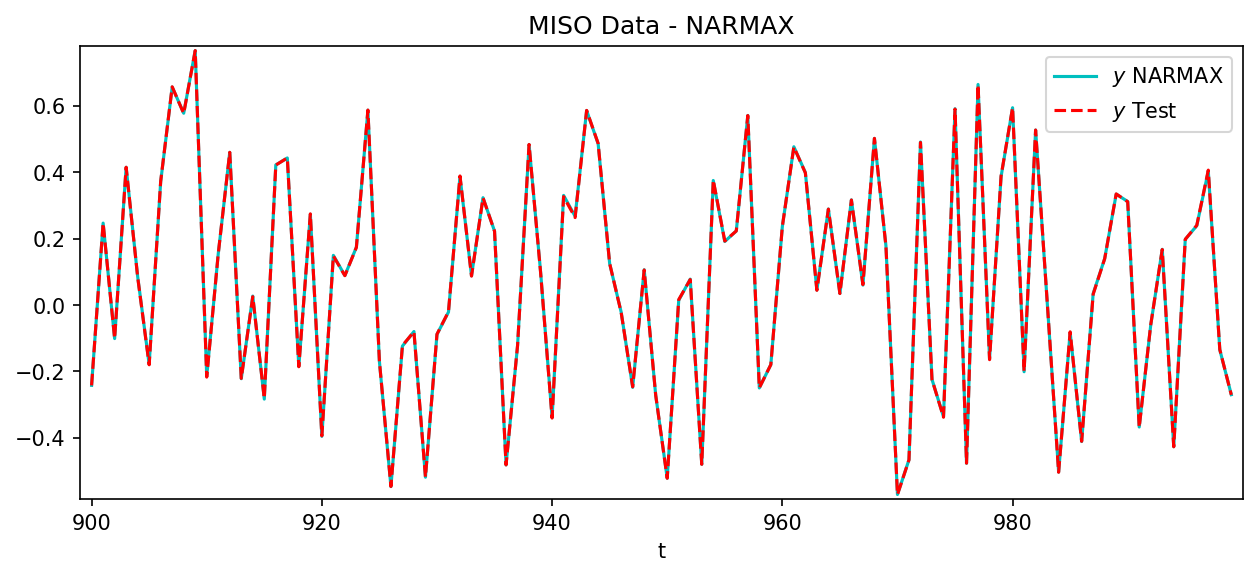

In [12]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('MISO Data - NARMAX')
plt.plot(t_test, narmax_sim, "c", label="$y$ NARMAX")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [13]:
# Define SINDy Model with control (SINDYc)
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['y', 'x1_k-1', 'x2_k-1', 'x1_k-2', 'x2_k-2'],
    discrete_time=True
)
# Fit model and get time taken
u_train = np.hstack((x_train[1:], x_train[:-1]))
tic = time.time()
sindy_model.fit(y_train[1:], u=u_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
first = np.hstack((x_valid[0], x_train[-1])) # First Input is needed to simulate y_valid[1]
u_test = np.hstack((x_valid[1:], x_valid[:-1]))
u_test = np.vstack((first, u_test)).reshape(-1, 1, u_train.shape[1])
sindy_sim = sindy_model.simulate(y_valid[0], t=len(y_valid), u=u_test)[:,0]

y[k+1] = 0.600 x2_k-1[k] + 0.400 y[k]^2 + 0.100 y[k] x1_k-1[k] + -0.300 x1_k-1[k] x2_k-2[k]


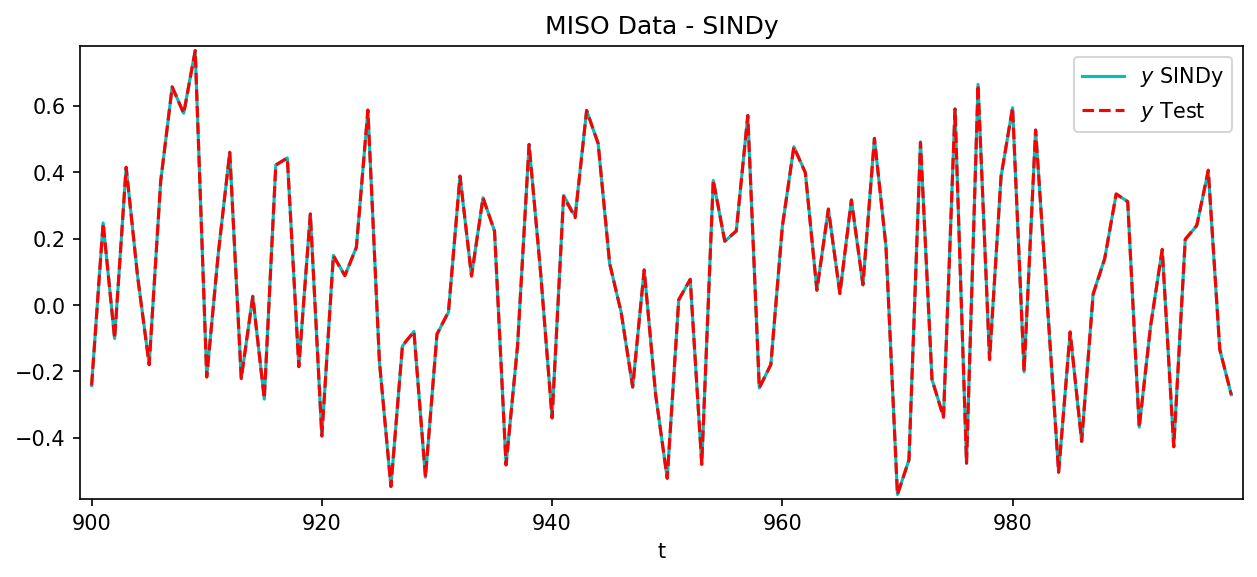

In [14]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('MISO Data - SINDy')
plt.plot(t_test, sindy_sim, "c", label="$y$ SINDy")
plt.plot(t_test, y_valid, "r--", label="$y$ Test")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.legend()
print(end='')

In [15]:
# Metrics DataFrame
get_metrics_df(y_valid, [4], sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[4.0],[0.0],4.0,-0.000097,0.000001,14.141101,0.999988,0.025068
NARMAX,[4.0],[0.0],4.0,-0.000092,0.000001,0.003466,0.999988,0.047387
